In [316]:
import sys  
sys.path.insert(0, './')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [317]:
# Filtered to just Bananas
df = pd.read_csv('../tutorial/tutorial.csv', index_col='timestamp', delimiter=';')
df = df.loc[df['product']=='BANANAS']
df = df[['mid_price']]
df.head()

,mid_price
timestamp,
0,4949.0
100,4947.5
200,4948.0
300,4948.5
400,4949.0


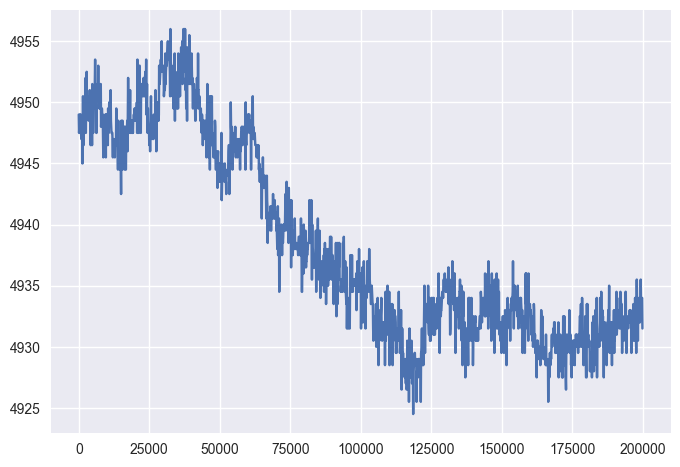

In [332]:
plt.plot(df)

# ARIMA Model

## AR

In [318]:
def ar_process(eps, phi):
    """
    Creates a AR process with a zero mean.
    """
    # Reverse the order of phi and add a 1 for current eps_t
    phi = np.r_[1, phi][::-1]
    ar = eps.copy()
    offset = len(phi)
    for i in range(offset, ar.shape[0]):
        ar[i - 1] = ar[i - offset: i] @ phi
    return ar

## MA

In [319]:
n = 500
eps = np.random.normal(size=n)


def lag_view(x, order):
    """
    For every value X_i create a row that lags k values: [X_i-1, X_i-2, ... X_i-k]
    """
    y = x.copy()
    # Create features by shifting the window of `order` size by one step.
    # This results in a 2D array [[t1, t2, t3], [t2, t3, t4], ... [t_k-2, t_k-1, t_k]]
    x = np.array([y[-(i + order):][:order] for i in range(y.shape[0])])

    # Reverse the array as we started at the end and remove duplicates.
    # Note that we truncate the features [order -1:] and the labels [order]
    # This is the shifting of the features with one time step compared to the labels
    x = np.stack(x)[::-1][order - 1: -1]
    y = y[order:]

    return x, y

def ma_process(eps, theta):
    """
    Creates an MA(q) process with a zero mean (mean not included in implementation).
    :param eps: (array) White noise signal.
    :param theta: (array/ list) Parameters of the process.
    """
    # reverse the order of theta as Xt, Xt-1, Xt-k in an array is Xt-k, Xt-1, Xt.
    theta = np.array([1] + list(theta))[::-1][:, None]
    eps_q, _ = lag_view(eps, len(theta))
    return eps_q @ theta

## Differencing

In [320]:

def difference(x, d=1):
    return np.diff(x, d)

def undo_difference(x, x_diff):
    return np.concatenate(([x[0]], x_diff)).cumsum()

## Main Class

In [321]:
def least_squares(x, y):
    if np.linalg.det(x.T @ x) != 0:
        return np.linalg.inv((x.T @ x)) @ (x.T @ y)
    return np.linalg.pinv((x.T @ x)) @ (x.T @ y) 

class LinearModel:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.beta = None
        self.intercept_ = None
        self.coef_ = None

    def _prepare_features(self, x):
        if self.fit_intercept:
            x = np.hstack((np.ones((x.shape[0], 1)), x))
        return x

    def fit(self, x, y):
        x = self._prepare_features(x)
        self.beta = least_squares(x, y)
        if self.fit_intercept:
            self.intercept_ = self.beta[0]
            self.coef_ = self.beta[1:]
        else:
            self.coef_ = self.beta

    def predict(self, x):
        x = self._prepare_features(x)
        return x @ self.beta

    def fit_predict(self, x, y):
        self.fit(x, y)
        return self.predict(x)


class ARIMA(LinearModel):
    def __init__(self, q, d, p):
        """
        An ARIMA model.
        :param q: (int) Order of the MA model.
        :param p: (int) Order of the AR model.
        :param d: (int) Number of times the data needs to be differenced.
        """
        super().__init__(True)
        self.p = p
        self.d = d
        self.q = q
        self.ar = None
        self.resid = None

    def prepare_features(self, x):
        if self.d > 0:
            x = difference(x, self.d)

        ar_features = None
        ma_features = None

        # Determine the features and the epsilon terms for the MA process
        if self.q > 0:
            if self.ar is None:
                self.ar = ARIMA(0, 0, self.p)
                self.ar.fit_predict(x)
            eps = self.ar.resid
            eps[0] = 0

            # prepend with zeros as there are no residuals_t-k in the first X_t
            ma_features, _ = lag_view(np.r_[np.zeros(self.q), eps], self.q)

        # Determine the features for the AR process
        if self.p > 0:
            # prepend with zeros as there are no X_t-k in the first X_t
            ar_features = lag_view(np.r_[np.zeros(self.p), x], self.p)[0]

        if ar_features is not None and ma_features is not None:
            n = min(len(ar_features), len(ma_features))
            ar_features = ar_features[:n]
            ma_features = ma_features[:n]
            features = np.hstack((ar_features, ma_features))
        elif ma_features is not None:
            n = len(ma_features)
            features = ma_features[:n]
        else:
            n = len(ar_features)
            features = ar_features[:n]

        return features, x[:n]

    def fit(self, x):
        features, x = self.prepare_features(x)
        super().fit(features, x)
        return features

    def fit_predict(self, x):
        """
        Fit and transform input
        :param x: (array) with time series.
        """
        features = self.fit(x)
        return self.predict(x, prepared=(features))

    def predict(self, x, **kwargs):
        """
        :param x: (array)
        :kwargs:
            prepared: (tpl) containing the features, eps and x
        """
        features = kwargs.get('prepared', None)
        if features is None:
            features, x = self.prepare_features(x)

        y = super().predict(features)
        self.resid = x - y

        return self.return_output(y)

    def return_output(self, x):
        if self.d > 0:
            x = undo_difference(x, self.d)
        return x

    def forecast(self, x, n):
        """
        Forecast the time series.
        :param x: (array) Current time steps.
        :param n: (int) Number of time steps in the future.
        """
        features, x = self.prepare_features(x)
        y = super().predict(features)

        # Append n time steps as zeros. Because the epsilon terms are unknown
        y = np.r_[y, np.zeros(n)]
        for i in range(n):
            feat = np.r_[y[-(self.p + n) + i: -n + i], np.zeros(self.q)]
            y[x.shape[0] + i] = super().predict(feat[None, :])
        return self.return_output(y)

In [425]:
m = ARIMA(1,0,5)
df_prices = df['mid_price'].to_numpy()
# print(df_prices[:-1])
appended = np.concatenate(([df_prices[0]],df_prices[:-1]))
x = difference(appended)
pred = m.fit_predict(x)
forec = m.forecast(pred,1)
# plt.plot(df_prices)
# plt.scatter(range(0,pred.size),pred, marker ="o", alpha=0.5, edgecolor ="red", c="red", s=10)
# plt.show()

In [426]:
print(undo_difference(appended, forec))

[4949.         4949.00560101 4949.01476052 ... 4935.90862669 4935.01824466
 4932.96461977]


In [427]:
df_prices

array([4949. , 4947.5, 4948. , ..., 4934. , 4934. , 4931.5])

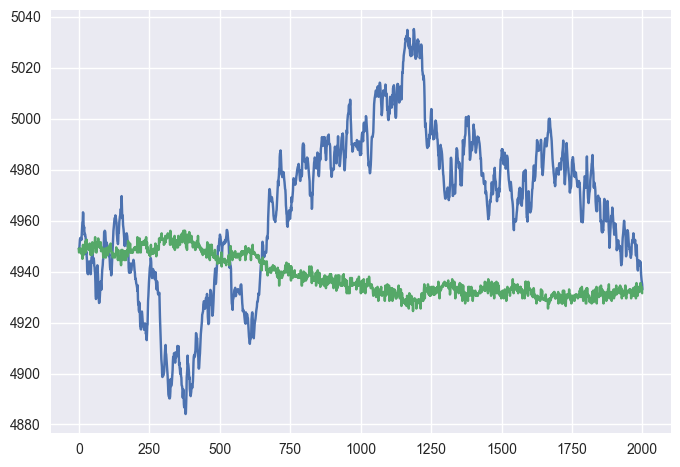

In [419]:
plt.plot(undo_difference(np.concatenate(([df_prices[0]],df_prices[:-1])), forec))
plt.plot(df_prices)


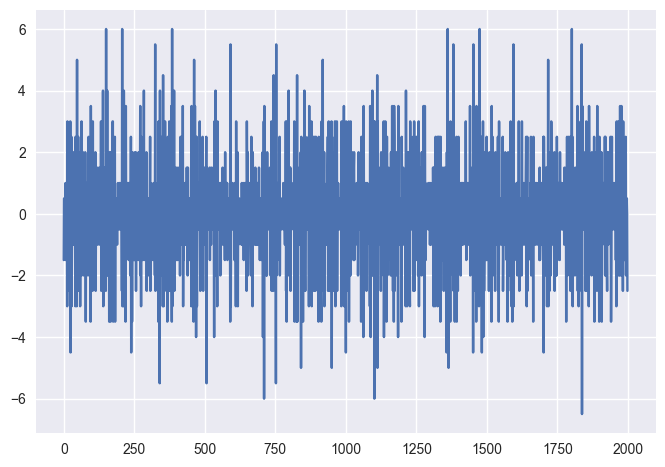

In [420]:
plt.plot(difference(df_prices))